# DS SC22x
 
### 코비 브라이언트의 슛 성공 여부 예측해보기

이번 스프린트 챌린지에서는 故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

여러분은 각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해야 합니다. 이것은 상당히 어려운 예측입니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집 됐습니다. 

In [7]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    #!pip install category_encoders==2.*
    #!pip install pandas-profiling==2.*

In [8]:
# 데이터셋을 불러옵니다
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

# Part 1 - Data Preprocessing

## 1.1 분류를 위한 베이스라인 정확도를 계산하세요
>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산하세요.

In [9]:
# 이 곳에 답안을 작성하십시오
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season


In [10]:
df['shot_made_flag'].value_counts(normalize=True)

# 전부 0으로 분류했을 시 정확도는 약 55.2692 % 확률로 옳게 분류

0    0.552692
1    0.447308
Name: shot_made_flag, dtype: float64

In [11]:
target = 'shot_made_flag'

y = df[target]
major = y.mode()

#기준모델 생성
major = y.mode()[0]
y_pred = [major]*len(y)

#기준모델 정확도 확인
from sklearn.metrics import accuracy_score
print('basline accuracy score:',accuracy_score(y, y_pred))

basline accuracy score: 0.5526924455158485


## 1.2 모델의 예측 정확도를 시험하기 위한 test set을 만드세요.

> 예측 모델 시험을 위해 2014-15 ~ 2015-16 시즌을 test set으로 만듭니다. NBA 시즌은 10월에 시작해서 6월에 종료합니다. 테스트셋에 **1826개**의 데이터가 있다면 알맞게 분할한 것입니다.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            30697 non-null  int64 
 1   game_event_id      30697 non-null  int64 
 2   player_name        30697 non-null  object
 3   period             30697 non-null  int64 
 4   minutes_remaining  30697 non-null  int64 
 5   seconds_remaining  30697 non-null  int64 
 6   action_type        30697 non-null  object
 7   shot_type          30697 non-null  object
 8   shot_zone_basic    30697 non-null  object
 9   shot_zone_area     30697 non-null  object
 10  shot_zone_range    30697 non-null  object
 11  shot_distance      30697 non-null  int64 
 12  loc_x              30697 non-null  int64 
 13  loc_y              30697 non-null  int64 
 14  shot_made_flag     30697 non-null  int64 
 15  game_date          30697 non-null  object
 16  htm                30697 non-null  objec

In [13]:
df.isnull().sum()

game_id              0
game_event_id        0
player_name          0
period               0
minutes_remaining    0
seconds_remaining    0
action_type          0
shot_type            0
shot_zone_basic      0
shot_zone_area       0
shot_zone_range      0
shot_distance        0
loc_x                0
loc_y                0
shot_made_flag       0
game_date            0
htm                  0
vtm                  0
season_type          0
dtype: int64

In [14]:
# 이 곳에 답안을 작성하십시오
df['game_date'] = pd.to_datetime(df['game_date'])
test = df[(df['game_date']>='2014-10-01') & (df['game_date']<='2016-06-30')]

In [15]:
test

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
28871,21400003,76,Kobe Bryant,1,6,13,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,20,-54,201,0,2014-10-28,LAL,HOU,Regular Season
28872,21400003,94,Kobe Bryant,1,4,45,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-16,63,1,2014-10-28,LAL,HOU,Regular Season
28873,21400003,413,Kobe Bryant,3,5,52,Turnaround Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,18,166,78,0,2014-10-28,LAL,HOU,Regular Season
28874,21400003,520,Kobe Bryant,4,9,36,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,27,-138,241,0,2014-10-28,LAL,HOU,Regular Season
28875,21400003,553,Kobe Bryant,4,7,16,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-179,88,0,2014-10-28,LAL,HOU,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,21501228,272,Kobe Bryant,3,9,45,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-96,237,0,2016-04-13,LAL,UTA,Regular Season
30693,21501228,274,Kobe Bryant,3,9,40,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,0,1,2016-04-13,LAL,UTA,Regular Season
30694,21501228,281,Kobe Bryant,3,9,0,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,31,-32,313,0,2016-04-13,LAL,UTA,Regular Season
30695,21501228,200,Kobe Bryant,2,4,56,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,6,-5,1,2016-04-13,LAL,UTA,Regular Season


In [16]:
train=df.drop(index=test.index)

In [17]:
print(test.shape)
print(train.shape)

(1826, 19)
(28871, 19)


## 1.3 새로운 feature를 만드세요

> 최소 1개 이상의 새로운 feature를 만드세요. 아래의 리스트를 사용하셔도 되고 스스로의 아이디어로 만들어 주셔도 괜찮습니다.
>- **Homecourt Advantage**: 홈 팀(`htm`)이 Los Angeles Lakers (`LAL`)인지 여부
>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Seconds remaining in the period**: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
>- **Seconds remaining in the game**: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부
    

In [18]:
# Homecourt Advantage: 홈 팀(htm)이 Los Angeles Lakers (LAL)인지 여부

df['Homecourt Advantage'] = 0
#test['Homecourt Advantage'] = 0

for i in range(len(df)):
  if df['htm'].iloc[i] == 'LAL':
    df['Homecourt Advantage'][i] = 1
  else:
    df['Homecourt Advantage'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [19]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,Homecourt Advantage
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,1
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,0
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season,0
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season,0
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season,0


In [20]:
# Opponent: LA Lakers를 상대하는 팀을 나타내는 feature

df['Opponent'] = 0
#test['Opponent'] = 0

for i in range(len(df)):
    string = df['htm'][i] + df['vtm'][i]
    df['Opponent'][i] = string.replace('LAL', '')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [21]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,Homecourt Advantage,Opponent
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,1,MIN
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,0,NYK
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season,0,CHH
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season,0,CHH
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season,0,CHH


In [22]:
# 불필요한 피쳐 삭제

df.drop(['game_id', 'game_event_id', 'player_name', 'htm', 'vtm'], axis = 1, inplace=True)
#df.head()

## 1.4 모델을 어떻게 검증할지 결정한 후에 데이터셋을 분할하세요. 

>아래의 검증 방법 중 하나를 선택한 후 목적에 맞게 데이터를 분할 하세요. 어떤 방법을 선택하는지 여부로 채점되지 않습니다 (두 방법 모두 좋은 방법입니다).
>
>- **Train/validate/test split을 통한 검증 (Hold-out Validation): 무작위로 80/20% 비율로 나누기**
>- **독립적인 test set으로 Cross-validation을 통한 검증**. scikit-learn에 있는 모든 cross-validation 방법을 활용하셔도 됩니다.

In [23]:
# 이 곳에 답안을 작성하십시오

# 위에서 이미 test 셋은 분리 했으니, train 셋을 train 과 validation 셋으로 분리한다.
df['game_date'] = pd.to_datetime(df['game_date'])
test = df[(df['game_date']>='2014-10-01') & (df['game_date']<='2016-06-30')]
train=df.drop(index=test.index)

from sklearn.model_selection import train_test_split

train, validation = train_test_split(train, test_size=0.2, random_state=42)

train.drop(['game_date'], axis=1, inplace=True)
validation.drop(['game_date'], axis=1, inplace=True)
test.drop(['game_date'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
print(train.shape)
print(validation.shape)
print(test.shape)

(23096, 15)
(5775, 15)
(1826, 15)


In [25]:
# 타겟, 피쳐 분리

target = 'shot_made_flag'

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = validation[features]
y_val = validation[target]
X_test = test[features]
y_test = test[target]

# Part 2 - Modeling & Evaluation

## 2.1 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인을 구축하세요
>Scikit-learn의 `pipeline`을 활용합니다.

In [26]:
# 이 곳에 답안을 작성하십시오
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23096 entries, 9926 to 23654
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   period               23096 non-null  int64 
 1   minutes_remaining    23096 non-null  int64 
 2   seconds_remaining    23096 non-null  int64 
 3   action_type          23096 non-null  object
 4   shot_type            23096 non-null  object
 5   shot_zone_basic      23096 non-null  object
 6   shot_zone_area       23096 non-null  object
 7   shot_zone_range      23096 non-null  object
 8   shot_distance        23096 non-null  int64 
 9   loc_x                23096 non-null  int64 
 10  loc_y                23096 non-null  int64 
 11  shot_made_flag       23096 non-null  int64 
 12  season_type          23096 non-null  object
 13  Homecourt Advantage  23096 non-null  int64 
 14  Opponent             23096 non-null  object
dtypes: int64(8), object(7)
memory usage: 2.8+ MB


In [28]:
train.head(2)

,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,season_type,Homecourt Advantage,Opponent
9926,4,7,29,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,19,174,94,1,Playoffs,1,MIN
11402,2,1,59,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,18,90,163,0,Playoffs,0,SAS


In [29]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), # r결측값은 없지만
    RandomForestClassifier(random_state=42, n_estimators=100,oob_score=True )
)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'season_type',
                                      'Opponent'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                          1
Turnaround Jump Shot               2
Driving Jump shot                  3
Layu...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                 

## 2.2 검증셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요.
>1.4에서 Cross-validation으로 진행한 경우는 그냥 cv score를 작성하세요.

In [31]:
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

In [32]:
# 이 곳에 답안을 작성하십시오
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
print('----------')
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred))

훈련 정확도:  0.9997402147558019
검증 정확도:  0.6644155844155845
----------
훈련 정확도(f1_score): 0.999712395743457
검증 정확도(f1_score): 0.5851883561643836


## 2.3 테스트셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요

In [33]:
# 이 곳에 답안을 작성하십시오
y_test_pred = pipe.predict(X_test)

print('test 정확도: ', pipe.score(X_test, y_test))
print('test 정확도(f1_score):', f1_score(y_test, y_test_pred))

test 정확도:  0.6686746987951807
test 정확도(f1_score): 0.5454545454545455


# Part 3 - Confusion Matrix
### 다음 confusion matrix를 사용해서 accuracy, precision, recall을 계산하세요. 아래의 테이블이 이진분류 모델의 confusion matrix라고 생각하고 계산하세요.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2" align='center'><b>Predicted</b></td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
      <td rowspan="2"><b>Actual</b></td>
    <td>Negative</td>
    <td style="border: solid" align='center'>85</td>
    <td style="border: solid" align='center'>58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid" align='center'>8</td>
    <td style="border: solid" align='center'> 36</td>
  </tr>
</table>

### a) Accuracy score를 계산하세요

In [34]:
# 이 곳에 답안을 작성하십시오
tp = 36
tn = 85
fp = 58
fn = 8
total = tp + tn + fp + fn

In [35]:
real_positives = tp + tn
accuracy=real_positives/total

accuracy

0.6470588235294118

### b) Precision score를 계산하세요 

In [36]:
# 이 곳에 답안을 작성하십시오

positives = tp + fp
precision=tp/positives

precision

0.3829787234042553

### c) Recall score를 계산하세요

In [37]:
real_positives = tp + fn
recall=tp / real_positives

recall

0.8181818181818182

In [38]:
# Advanced Goals

'''
>**3점**을 획득하기 위해선 아래의 **"모든 조건"**을 만족해야합니다. 
- **4개** 이상의 새로운 feature들을 만드세요. 1.3에 있는 feature들을 포함해서 만드셔도 괜찮습니다.
- `feature들`과 `target`의 관계를 보여주는 시각화를 **2개** 이상 해주세요.
- 최소 3개의 하이퍼 파라미터를 사용해서 가능한 조합이 10개 이상이 되도록해서 최적화 하세요.`RandomizedSearchCV`나 `GridSearchCV`를 사용하거나 임의로 조합을 만들어도 상관 없습니다.
- `feature importance`를 계산하고 시각화 해주세요.
'''

'\n>**3점**을 획득하기 위해선 아래의 **"모든 조건"**을 만족해야합니다. \n- **4개** 이상의 새로운 feature들을 만드세요. 1.3에 있는 feature들을 포함해서 만드셔도 괜찮습니다.\n- `feature들`과 `target`의 관계를 보여주는 시각화를 **2개** 이상 해주세요.\n- 최소 3개의 하이퍼 파라미터를 사용해서 가능한 조합이 10개 이상이 되도록해서 최적화 하세요.`RandomizedSearchCV`나 `GridSearchCV`를 사용하거나 임의로 조합을 만들어도 상관 없습니다.\n- `feature importance`를 계산하고 시각화 해주세요.\n'

In [39]:
X_train['period']

9926     4
11402    2
5929     4
21887    2
27214    1
        ..
21575    4
5390     4
860      4
15795    4
23654    3
Name: period, Length: 23096, dtype: int64

In [40]:
# 이 곳에 답안을 작성하십시오

'''
다음 두개의 피쳐 추가 생성

Seconds remaining in the period: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
Seconds remaining in the game: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
'''

X_train['Seconds remaining in the period'] = 0
X_val['Seconds remaining in the period'] = 0
X_test['Seconds remaining in the period'] = 0

X_train['Seconds remaining in the game'] = 0
X_val['Seconds remaining in the game'] = 0
X_test['Seconds remaining in the game'] = 0

In [41]:
## 정규 쿼터는 12분이지만 연장전은 5분씩이라고 한다
# 게임에서 남은 시간을 연장전을 감안해서 고려할지, 안할지는 추가적인 고민이 필요해보인다.
# period가 단순히 득점시의 쿼터였다면 연장전이 있는 게임일 경우, 남은 시간 계산은 매번 달라지게 된다.
# period가 게임 종료까지 남은 쿼터라면 정규 쿼터는 12분, 연장 쿼터는 5분씩 추가하면 된다.
# 본 분석에서는 그냥 period가 게임 종료까지 남은 쿼터라고 가정하고 진행하였다.

In [42]:
for i in range(len(X_train)):
    X_train['Seconds remaining in the period'].iloc[i] = X_train['minutes_remaining'].iloc[i] * 60 + X_train['seconds_remaining'].iloc[i]
    if X_train['period'].iloc[i] <= 4:
      X_train['Seconds remaining in the game'].iloc[i] = X_train['period'].iloc[i] * 12 * 60 + X_train['seconds_remaining'].iloc[i]
    else:
      X_train['Seconds remaining in the game'].iloc[i] = (4 * 12 * 60) + (X_train['period'].iloc[i] - 4) * 5 * 60 + X_train['seconds_remaining'].iloc[i]

for i in range(len(X_val)):
    X_val['Seconds remaining in the period'].iloc[i] = X_val['minutes_remaining'].iloc[i] * 60 + X_val['seconds_remaining'].iloc[i]
    if X_val['period'].iloc[i] <= 4:
      X_val['Seconds remaining in the game'].iloc[i] = X_val['period'].iloc[i] * 12 * 60 + X_val['seconds_remaining'].iloc[i]
    else:
      X_val['Seconds remaining in the game'].iloc[i] = (4 * 12 * 60) + (X_val['period'].iloc[i] - 4) * 5 * 60 + X_val['seconds_remaining'].iloc[i]

for i in range(len(X_test)):
    X_test['Seconds remaining in the period'].iloc[i] = X_test['minutes_remaining'].iloc[i] * 60 + X_test['seconds_remaining'].iloc[i]
    if X_test['period'].iloc[i] <= 4:
      X_test['Seconds remaining in the game'].iloc[i] = X_test['period'].iloc[i] * 12 * 60 + X_test['seconds_remaining'].iloc[i]
    else:
      X_test['Seconds remaining in the game'].iloc[i] = (4 * 12 * 60) + (X_test['period'].iloc[i] - 4) * 5 * 60 + X_test['seconds_remaining'].iloc[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [43]:
X_train.head(8)

,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,season_type,Homecourt Advantage,Opponent,Seconds remaining in the period,Seconds remaining in the game
9926,4,7,29,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,19,174,94,Playoffs,1,MIN,449,2909
11402,2,1,59,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,18,90,163,Playoffs,0,SAS,119,1499
5929,4,3,38,Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,5,38,Regular Season,1,ORL,218,2918
21887,2,8,2,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,15,-150,14,Regular Season,1,HOU,482,1442
27214,1,7,57,Turnaround Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,7,124,Regular Season,1,DAL,477,777
23618,4,3,55,Turnaround Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-57,118,Playoffs,1,BOS,235,2935
4424,4,11,47,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-71,192,Regular Season,1,SEA,707,2927
25512,3,10,39,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-187,178,Playoffs,1,DAL,639,2199


In [44]:
import seaborn as sns
loc = X_train[['loc_x', 'loc_y']]
loc.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

point = pd.concat([loc, y_train], axis = 1)

point

,loc_x,loc_y,shot_made_flag
0,174,94,1
1,90,163,0
2,5,38,0
3,-150,14,0
4,7,124,0
...,...,...,...
23091,-95,50,1
23092,-115,228,0
23093,-111,31,0
23094,156,54,0


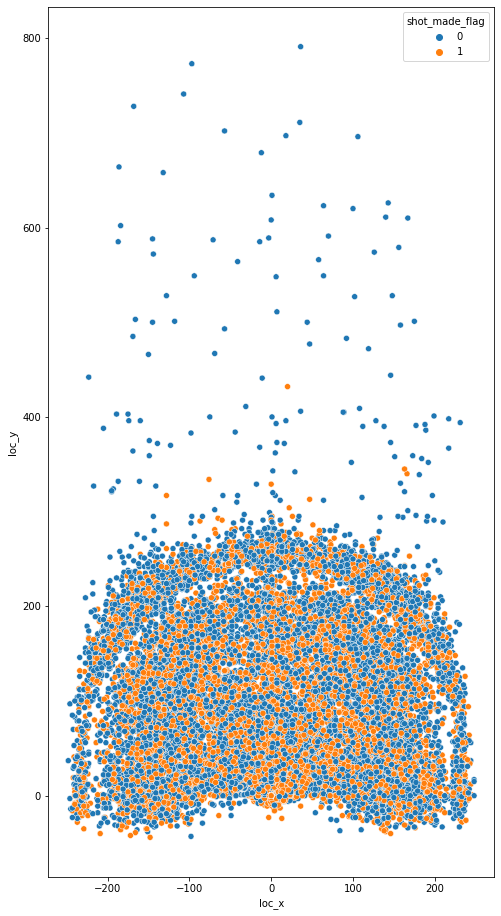

In [46]:
# 슛을 시도한 좌표와 성공 여부 시각화
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,16))

sns.scatterplot(data = point, x = point.loc_x, y = point.loc_y, hue = point.shot_made_flag);

In [47]:
opp = X_train[['Opponent']]
opp.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

opp = pd.concat([opp, y_train], axis = 1)

opp

,Opponent,shot_made_flag
0,MIN,1
1,SAS,0
2,ORL,0
3,HOU,0
4,DAL,0
...,...,...
23091,ORL,1
23092,MIL,0
23093,PHI,0
23094,CHI,0


In [48]:
stats = opp.groupby(['Opponent'])['shot_made_flag'].sum()

name = stats.index
num = stats.values

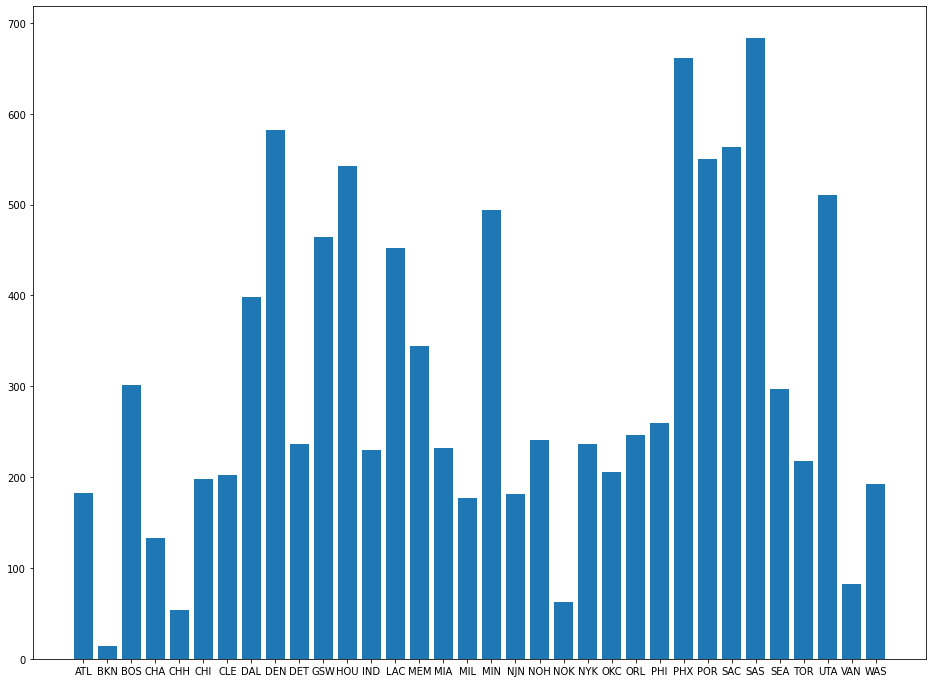

In [49]:
# 상대 팀에 따른 누적 득점 횟수 시각화

# SAS 팀을 상대로 가장 많은 득점을 기록, BKN 팀을 상대로 가장 적게 득점

plt.figure(figsize=(16,12))
plt.bar(name, num);

In [50]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV

enc = OrdinalEncoder()
imp = SimpleImputer()
X_train_encoded = enc.fit_transform(X_train)
X_train_imputed = imp.fit_transform(X_train_encoded)
X_val_encoded = enc.transform(X_val)
X_val_imputed = imp.transform(X_val_encoded)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth' : [8, 12, 16],
    'n_estimators' : [50, 100],
    'min_samples_leaf' : [4, 6, 8, 10, 12],
    'max_features' : ['sqrt', 'log2']
}


clf2 = GridSearchCV(
    rf_clf,
    param_grid=params,
    cv=3,
    n_jobs=-1
    )

clf2.fit(X_train_imputed, y_train)

print('최적 하이퍼파라미터: ', clf2.best_params_)
print('accuracy: ', clf2.best_score_)

pipe = clf2.best_estimator_

pipe.fit(X_val_imputed, y_val)
print('검증 정확도', pipe.score(X_val_imputed, y_val))

최적 하이퍼파라미터:  {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 100}
accuracy:  0.6765676790957175
검증 정확도 0.7489177489177489


In [51]:
X_test_encoded = enc.transform(X_test)
X_test_imputed = imp.transform(X_test_encoded)

In [52]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True, max_depth= 8, max_features= 'sqrt', min_samples_leaf=8, n_estimators= 100)
)

pipe.fit(X_test_imputed, y_test)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                         

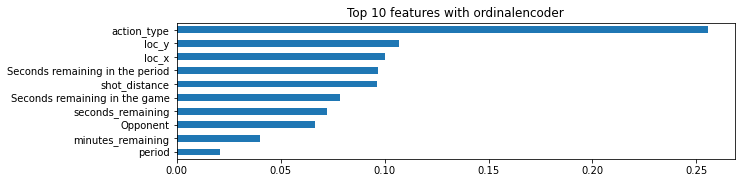

In [53]:
rf_ord = pipe.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_test_encoded.columns)

n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with ordinalencoder')
importances_ord.sort_values()[-n:].plot.barh();